# Check particle interaction strength and compare with $g(\theta)$

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import math
import tqdm.auto as tqdm

sys.path.insert(0,"../magcolloids")

import magcolloids as mgc
from IPython.display import HTML

idx = pd.IndexSlice
%reload_ext autoreload
%autoreload 2

In [2]:
ureg = mgc.ureg

### Below we define the functions that calculate the correlations

In [3]:
def angular_distance(theta1,theta2):
    """Takes two angles and returns the smallest difference between the two."""
    delta = theta1-theta2
    logical = np.abs(delta)>np.pi
    delta[logical] = np.sign(delta[logical])*2*np.pi-delta[logical]
    return delta

def single_particle_correlation(trajectory,particle,bins):
    """ Returns the probability of finding a particle at a given angle from particle `particle`. 
    Uses angular_distance to define $\Delta\Theta$"""
    
    """M is the number of frames, N is the number of particles"""
    M = len(trajectory.index.get_level_values("frame").unique())
    N = len(trajectory.index.get_level_values("id").unique())
    n = len(bins)
    """ Calculate distance from current particle to all particles for each frame"""
    delta_theta = angular_distance(trajectory,trajectory.loc[idx[:,particle]])
    
    """ Drop all the self distances """
    delta_theta = abs(delta_theta.drop(particle,level='id')) 
    """ For some reason, there is NaN. Drop them."""
    delta_theta = delta_theta.dropna()

    normalization = n/(M*N)
    
    """Calculate histogram"""
    H,bins = np.histogram(delta_theta.values, bins = bins)
    
    return H*normalization

def calculate_g_of_theta(trajectory, bins = None, col_name = ""):
    """ Uses single_particle_correlation to calculate g(theta) for each particle in trajectory. 
    Averages and returns them in a pandas DataFrame"""
    
    if bins is None:
        bins = np.linspace(0,np.pi,100)

    H = np.mean(
        np.array(
            [single_particle_correlation(trajectory,i,bins) 
             for i in tqdm.tqdm(trajectory.index.get_level_values("id").unique())]),
        axis=0)


    g_of_theta = pd.DataFrame(data=H,index=(bins[0:-1]+bins[1:])/2,columns=[col_name])

    g_of_theta.index.name="theta"

    return g_of_theta

### We start by the $10\mu{}m$ system, and we first run a system on a line with periodic boundary conditions.

In [4]:
# parameters
N_particles = 11
radius_circle = 10*ureg.um
radius_particles = 1.4*ureg.um

In [5]:
perimeter = radius_circle.magnitude*np.pi*2
region = [perimeter, 3.2, 3.2] 
region
#initial_conditions = np.arr

[62.83185307179586, 3.2, 3.2]

In [6]:
pos_o = np.arange(0,N_particles)*perimeter/N_particles
pos_o = pos_o-(pos_o[-1]-pos_o[0])/2
initial_conditions = pos_o.reshape((-1, 1))*[1,0,0]

In [7]:
particles = mgc.particles(
    initial_conditions*ureg.um,
    radius = radius_particles,
    susceptibility = 0.68,
    diffusion=0.07*ureg.um**2/ureg.s,  #coeficiente de difusion
    density = 0*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

field = mgc.field(magnitude = 0.807*ureg.mT, frequency = 0*ureg.Hz, angle = 0*ureg.degrees)

world = mgc.world(particles, temperature = 300*ureg.K,
                  region=region*ureg.um, boundaries = ['p','f','f'], walls = [False,True,True],
                  dipole_cutoff = 20*ureg.um)

sim = mgc.sim(dir_name = "./",file_name="test0",
        timestep = 1e-3*ureg.s, framerate = 30*ureg.Hz, total_time = 600*ureg.s,  #timestep = 1 ms son los pasos de integracion
        particles = particles, world = world, field = field)                      #total time es la duracion de la simulacion

In [8]:
sim.generate_scripts()
sim.run()

In [9]:
%%time 
sim.load()
trj = sim.lazy_read[::]

CPU times: user 55.8 s, sys: 1.15 s, total: 56.9 s
Wall time: 1min


In [10]:
%%time
frames = trj.index.get_level_values("frame").unique()
HTML(mgc.display_animation_direct(sim,trj.loc[idx[frames[0:100]],:],speedup=1))

CPU times: user 6.93 s, sys: 152 ms, total: 7.08 s
Wall time: 7.33 s


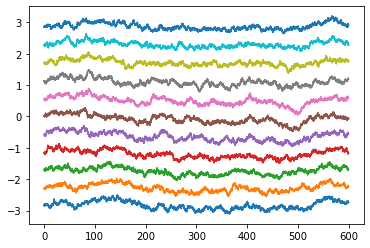

In [11]:
trj["th"] = trj.x/radius_circle.magnitude
for i, trj_i in trj.groupby("id"):
    plt.plot(trj_i.index.get_level_values("frame")*1e-3, np.unwrap(trj_i.th))

Text(0, 0.5, '$g(\\theta)$')

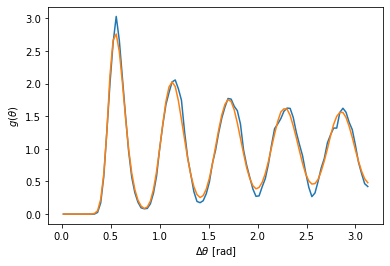

In [12]:
g_of_theta_lin_10 = calculate_g_of_theta(trj.query("frame>%u"%frames[int(len(frames)/3)]).th, 
                                  bins = np.linspace(0,np.pi,100), col_name = "Exp_1")

exps = pd.read_csv("g_of_theta.dat",sep="\t",index_col = 0)

plt.plot(g_of_theta_lin_10)
plt.plot(exps.Exp_1)
plt.xlabel(r"$\Delta \theta$ [rad]")
plt.ylabel(r"$g(\theta)$")

### Let's compare this with a system with circular traps

In [13]:
#initial_conditions
phi_p = np.linspace(0,2*np.pi,N_particles+1)[:-1]
x = np.cos(phi_p)*radius_circle.to(ureg.um).magnitude
y = np.sin(phi_p)*radius_circle.to(ureg.um).magnitude
z = 0*phi_p

initial_conditions = np.array([x,y,z]).transpose()

In [14]:
region = 3*radius_circle.to(ureg.um).magnitude*np.array([1,1,1])
region[2] = (2*radius_particles+0.5*ureg.um).to(ureg.um).magnitude

In [15]:
k = 1*ureg.fN/ureg.nm
"%2.2e"%k.to("pg/us**2").magnitude+str(k.to("pg/us**2").units)

'1.00e-03picogram / microsecond ** 2'

In [16]:
particles = mgc.particles(
    initial_conditions*ureg.um,
    radius = 1.4*ureg.um,
    susceptibility = 0.68,
    diffusion=0.07*ureg.um**2/ureg.s,  #coeficiente de difusion
    density = 0*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

In [17]:
force_calculation = """
# Remember that time is in microsecond
# Force is in pg*um/us^2
# k should be in pg/us^2
# r, cx and cy are in um

variable k atom 1e-2

variable R atom 10

variable rho atom sqrt(x*x+y*y)
variable ex atom x/v_rho
variable ey atom y/v_rho

variable dr atom v_rho-v_R

variable Fx atom -v_k*v_dr*v_ex
variable Fy atom -v_k*v_dr*v_ey
variable Fz atom 0

"""

In [18]:
traps = mgc.ext_force(calculation = force_calculation, variable = "v_F")

In [19]:
field = mgc.field(magnitude = 0.807*ureg.mT, frequency = 0*ureg.Hz, angle = 0*ureg.degrees)

world = mgc.world(particles, ext_force = traps, temperature = 300*ureg.K,
                  region=region*ureg.um, boundaries = ['f','f','f'], walls = [False,False,True],
                  dipole_cutoff = 20*ureg.um)

sim = mgc.sim(dir_name = ".", file_name = "ring_trap_test_ring_0",
       timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = 600*ureg.s,
       particles = particles, world = world, field = field)

In [20]:
sim.generate_scripts()
sim.run()

In [21]:
%%time 
sim.load()
trj = sim.lazy_read[::]

CPU times: user 53.7 s, sys: 1.07 s, total: 54.8 s
Wall time: 55.8 s


In [22]:
%%time
frames = trj.index.get_level_values("frame").unique()
HTML(mgc.display_animation_direct(sim,trj.loc[idx[frames[-100:-1]],:],speedup=1))

CPU times: user 8.56 s, sys: 229 ms, total: 8.79 s
Wall time: 9.12 s


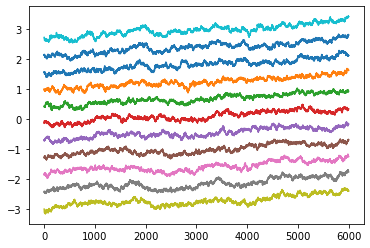

In [23]:
trj["th"] = np.arctan2(trj.x,trj.y)

for i, trj_i in trj.groupby("id"):
    plt.plot(trj_i.index.get_level_values("frame")*1e-3, np.unwrap(trj_i.th))

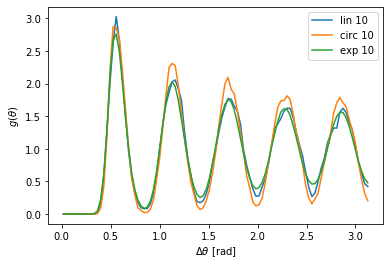

In [24]:
g_of_theta_circ_10 = calculate_g_of_theta(trj.query("frame>%u"%frames[int(len(frames)/3)]).th, 
                                  bins = np.linspace(0,np.pi,100), col_name = "Exp_1")

plt.plot(g_of_theta_lin_10)
plt.plot(g_of_theta_circ_10)
plt.plot(exps.Exp_1)
plt.xlabel(r"$\Delta \theta$ [rad]")
plt.ylabel(r"$g(\theta)$")
plt.legend(["lin 10", "circ 10", "exp 10"]);


## Now we calculate for $5\mu{}m$ circles with $\chi=0.4$.
### As before we compare linear and circular traps

In [25]:
# parameters
N_particles = 5
radius_circle = 5*ureg.um
radius_particles = 1.4*ureg.um

In [26]:
perimeter = radius_circle.magnitude*np.pi*2
region = [perimeter, 3.2, 3.2] 
region
#initial_conditions = np.arr

[31.41592653589793, 3.2, 3.2]

In [27]:
pos_o = np.arange(0,N_particles)*perimeter/N_particles
pos_o = pos_o-(pos_o[-1]-pos_o[0])/2
initial_conditions = pos_o.reshape((-1, 1))*[1,0,0]

In [28]:
particles = mgc.particles(
    initial_conditions*ureg.um,
    radius = radius_particles,
    susceptibility = 0.4,
    diffusion=0.07*ureg.um**2/ureg.s,  #coeficiente de difusion
    density = 0*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

field = mgc.field(magnitude = 0.807*ureg.mT, frequency = 0*ureg.Hz, angle = 0*ureg.degrees)

world = mgc.world(particles, temperature = 300*ureg.K,
                  region=region*ureg.um, boundaries = ['p','f','f'], walls = [False,True,True],
                  dipole_cutoff = 20*ureg.um)

sim = mgc.sim(dir_name = "./",file_name="test0",
        timestep = 1e-3*ureg.s, framerate = 30*ureg.Hz, total_time = 600*ureg.s,  #timestep = 1 ms son los pasos de integracion
        particles = particles, world = world, field = field)                      #total time es la duracion de la simulacion

In [29]:
sim.generate_scripts()
sim.run()

In [30]:
%%time 
sim.load()
trj = sim.lazy_read[::]

CPU times: user 57.1 s, sys: 1.36 s, total: 58.5 s
Wall time: 1min


In [31]:
%%time
frames = trj.index.get_level_values("frame").unique()
HTML(mgc.display_animation_direct(sim,trj.loc[idx[frames[0:100]],:],speedup=1))

CPU times: user 7.08 s, sys: 164 ms, total: 7.24 s
Wall time: 7.59 s


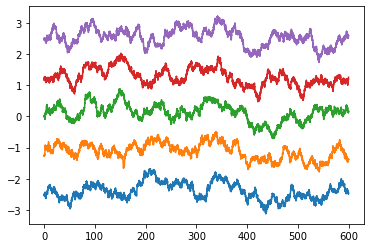

In [32]:
trj["th"] = trj.x/radius_circle.magnitude

for i, trj_i in trj.groupby("id"):
    plt.plot(trj_i.index.get_level_values("frame")*1e-3, np.unwrap(trj_i.th))

In [33]:
g_of_theta_lin_5 = calculate_g_of_theta(trj.query("frame>%u"%frames[int(len(frames)/3)]).th, 
                                  bins = np.linspace(0,np.pi,100), col_name = "Exp_1")

Text(0, 0.5, '$g(\\theta)$')

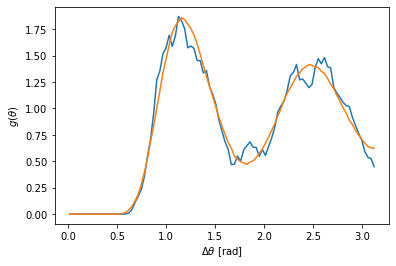

In [34]:
exps = pd.read_csv("g_of_theta.dat",sep="\t",index_col = 0)

plt.plot(g_of_theta_lin_5)
plt.plot(exps.Exp_10)
plt.xlabel(r"$\Delta \theta$ [rad]")
plt.ylabel(r"$g(\theta)$")

# Now with circular traps

In [35]:
#initial_conditions
phi_p = np.linspace(0,2*np.pi,N_particles+1)[:-1]
x = np.cos(phi_p)*radius_circle.to(ureg.um).magnitude
y = np.sin(phi_p)*radius_circle.to(ureg.um).magnitude
z = 0*phi_p

initial_conditions = np.array([x,y,z]).transpose()

In [36]:
region = 3*radius_circle.to(ureg.um).magnitude*np.array([1,1,1])
region[2] = (2*radius_particles+1*ureg.um).to(ureg.um).magnitude

In [37]:
k = 1*ureg.fN/ureg.nm
"%2.2e"%k.to("pg/us**2").magnitude+str(k.to("pg/us**2").units)

'1.00e-03picogram / microsecond ** 2'

In [38]:
particles = mgc.particles(
    initial_conditions*ureg.um,
    radius = 1.4*ureg.um,
    susceptibility = 0.4,
    diffusion=0.07*ureg.um**2/ureg.s,  #coeficiente de difusion
    density = 0*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

In [39]:
force_calculation = """
# Remember that time is in microsecond
# Force is in pg*um/us^2
# k should be in pg/us^2
# r, cx and cy are in um

variable k atom 1e-2

variable R atom 5

variable rho atom sqrt(x*x+y*y)
variable ex atom x/v_rho
variable ey atom y/v_rho

variable dr atom v_rho-v_R

variable Fx atom -v_k*v_dr*v_ex
variable Fy atom -v_k*v_dr*v_ey
variable Fz atom 0

"""

In [40]:
traps = mgc.ext_force(calculation = force_calculation, variable = "v_F")

In [41]:
field = mgc.field(magnitude = 0.807*ureg.mT, frequency = 0*ureg.Hz, angle = 0*ureg.degrees)

world = mgc.world(particles, ext_force = traps, temperature = 300*ureg.K,
                  region=region*ureg.um, boundaries = ['f','f','f'], walls = [True,True,True],
                  dipole_cutoff = 20*ureg.um)

sim = mgc.sim(dir_name = ".", file_name = "ring_trap_test_ring_0",
       timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = 600*ureg.s,
       particles = particles, world = world, field = field)

In [42]:
sim.generate_scripts()
sim.run()

In [43]:
%%time 
sim.load()
trj = sim.lazy_read[::]

CPU times: user 53.1 s, sys: 1.06 s, total: 54.2 s
Wall time: 55.8 s


In [44]:
%%time
frames = trj.index.get_level_values("frame").unique()
HTML(mgc.display_animation_direct(sim,trj.loc[idx[frames[-100:-1]],:],speedup=1))

CPU times: user 7.96 s, sys: 227 ms, total: 8.19 s
Wall time: 8.52 s


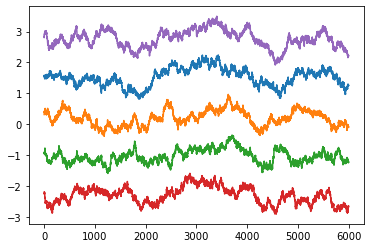

In [45]:
trj["th"] = np.arctan2(trj.x,trj.y)

for i, trj_i in trj.groupby("id"):
    plt.plot(trj_i.index.get_level_values("frame")*1e-3, np.unwrap(trj_i.th))

In [46]:
g_of_theta_circ_5 = calculate_g_of_theta(trj.query("frame>%u"%frames[int(len(frames)/3)]).th, 
                                  bins = np.linspace(0,np.pi,100), col_name = "Exp_1")

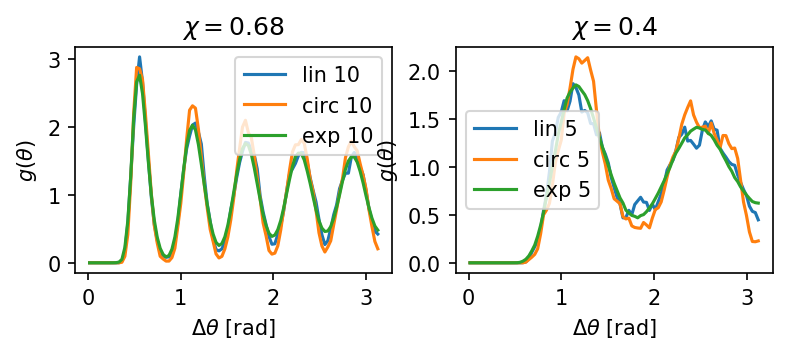

In [48]:
fig, ax = plt.subplots(1,2,dpi=150,figsize=(6,2))
exps = pd.read_csv("g_of_theta.dat",sep="\t",index_col = 0)

plt.sca(ax[0])
plt.plot(g_of_theta_lin_10)
plt.plot(g_of_theta_circ_10)
plt.plot(exps.Exp_1)
plt.xlabel(r"$\Delta \theta$ [rad]")
plt.ylabel(r"$g(\theta)$")
plt.legend(["lin 10", "circ 10", "exp 10"])
plt.title(r"$\chi=0.68$")

plt.sca(ax[1])
plt.plot(g_of_theta_lin_5)
plt.plot(g_of_theta_circ_5)
plt.plot(exps.Exp_10)
plt.xlabel(r"$\Delta \theta$ [rad]")
plt.ylabel(r"$g(\theta)$")
plt.legend(["lin 5", "circ 5", "exp 5"])
plt.title(r"$\chi=0.4$");